# basic of nlp

## 文本分类

https://www.zhihu.com/question/50888062/answer/1714628626
不同模型的适用场景不同，常用的模型有Fasttext/TextCNN/DPCNN/TextRCNN/BiLSTM+Attention/HAN/BERT/Capsule/TextGCN
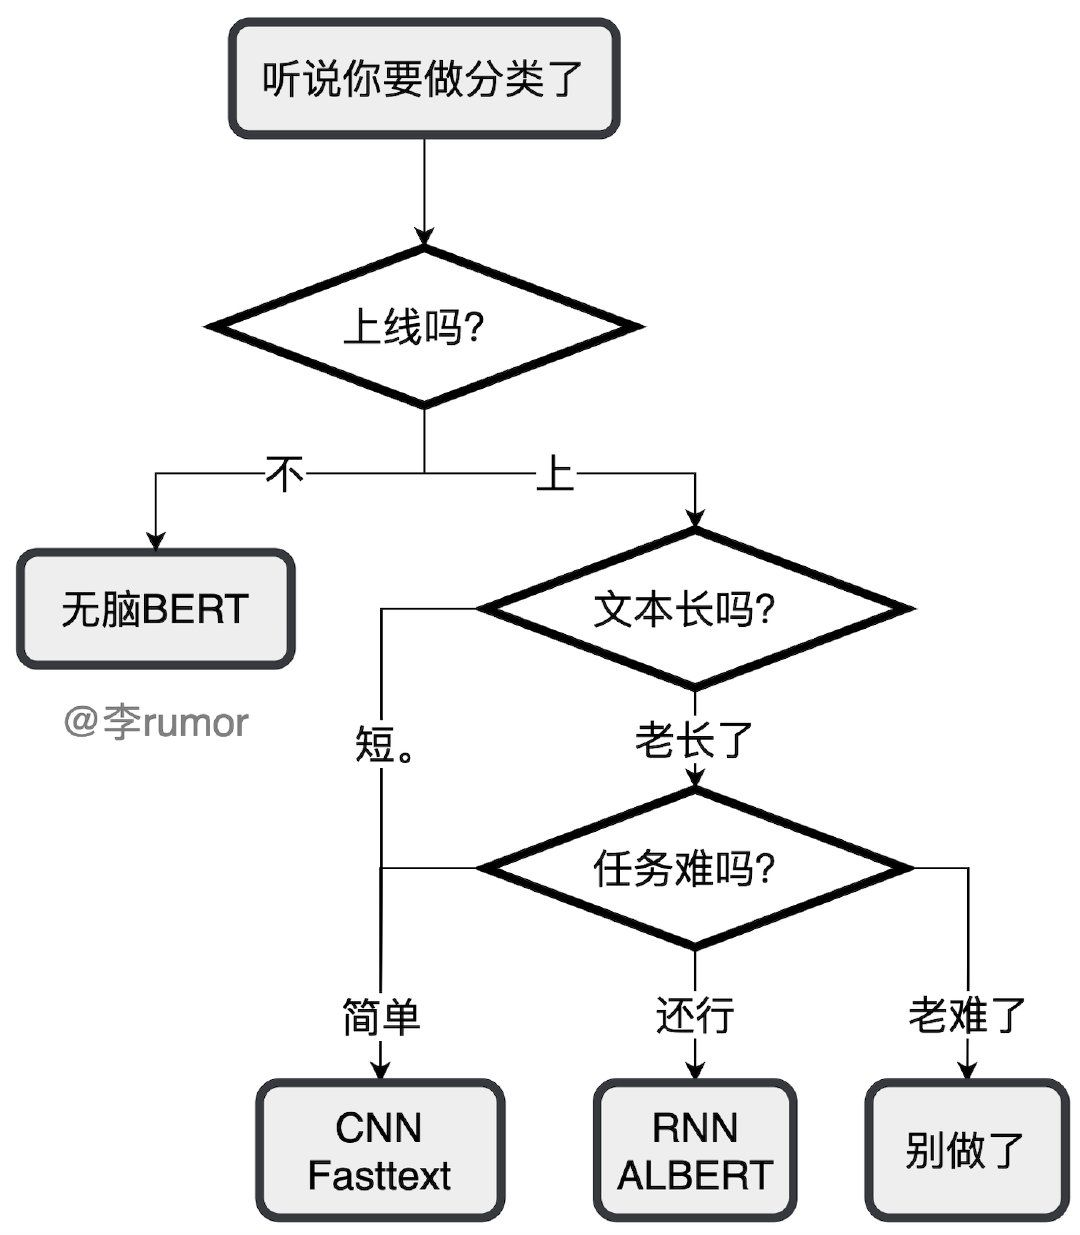

# Seq2seq

seq2seq是一种框架结构，它接受一个序列，再输出一个序列，由编码器和解码器两部分构成。 具体地，编码器处理输入序列中的每一项，将捕获的信息编译成一个向量（encoder）。处理完整个输入序列后，编码器将编码后的信息发送给解码器，解码器开始生成输出序列

# Attention机制
在attention机制出来之前，大多数人用的是rnn来捕捉输入序列的语义信息，但rnn存在长距离信息难以捕捉的问题。 attention机制源于人脑的认知原理，人类会选择性关注自己想关注的内容而忽略另外一部分，将attention机制融入NLP任务，就可以在适当的位置捕捉适当的信息。

## torch构建seq2seq + attention

In [1]:
# 构建seq2seq + attention
# encoder编码器

import torch.nn as nn
# 编码器
class EncoderRNN(nn.Module):
    def __init__(self,input_size,hidden_size):
        super(EncoderRNN,self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size,hidden_size)
        self.gru = nn.GRU(hidden_size,hidden_size)
    
    def forward(self,input,hidden):
        embedded = self.embedding(input).view(1,1,-1)
        output,hidden = self.gru(embedded,hidden)
        return output,hidden
    
    # 初始化隐状态
    def initHidden(self):
        return torch.zeros(1,1,self.hidden_size)

In [2]:
import torch.nn.functional as F
# 解码器
class AttnDecoderRNN(nn.Module):
    def __init__(self,hidden_size,output_size):
        super(AttnDecoderRNN,self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.embedding = nn.Embedding(
        self.output_size,self.hidden_size)
        self.gru = nn.GRU(self.hidden_size,self.hidden_size)
        self.out = nn.Linear(self.hidden_size*2,self.output_size)
        
    def forward(self,input,hidden,encoder_outputs):
        embedded = self.embedding(input).view(1,1,-1)
        embedded = F.relu(embedded)
        output,hidden = self.gru(embedded,hidden)
        
        # 注意力运算，由encoder_outputs和hidden进行内积
        attn_weights = F.softmax(torch.bmm(encoder_outputs.unsqueeze(
        0),hidden.view(1,self.hidden_size,-1)),dim=1)
        # 添加注意力机制的原文信息
        weighted_context = torch.matmul(
        attn_weights.squeeze(2),encoder_outputs)
        # 拼接当前信息以及添加注意力机制的原文信息
        output = torch.cat([output.squeeze(0),weighted_context],dim=1)
        # 对输出进行 softmax 计算
        output = F.softmax(self.out(output),dim=1)
        return output,hidden,attn_weights
    
    def initHidden(self):
        return torch.zeros(1,1,self.hidden_size)

In [3]:
# 对于编码器与解码器的尝试
import torch
INPUT_SIZE = 1000
HIDDEN_SIZE = 60
OUTPUT_SIZE = 1000

my_encoder = EncoderRNN(input_size = INPUT_SIZE,hidden_size=HIDDEN_SIZE)
my_decoder = AttnDecoderRNN(hidden_size=HIDDEN_SIZE,output_size=OUTPUT_SIZE)

# 编码过程
input = torch.tensor([[0],[4],[3],[1]])
encoder_hidden = my_encoder.initHidden()
input_length = input.size(0)
encoder_outputs = torch.zeros(input_length,my_encoder.hidden_size)
for i in range(input_length):
    encoder_output,encoder_hidden = my_encoder(input[i],encoder_hidden)
    encoder_outputs[i] = encoder_output[0,0]
encoder_outputs.shape

# 解码过程
decoder_input = torch.tensor([[0]])
decoder_hidden = encoder_hidden
decoder_output,decoder_hidden,decoder_attention = my_decoder(
decoder_input,decoder_hidden,encoder_outputs)
decoder_output.shape

torch.Size([1, 1000])

# Transformers

## Transformer的hugging face简易调包

In [5]:
# hugging face 调包
from transformers import pipeline
# 没一个用的时候要下载一个pipeline model

# 情感分类
emotion_classifier = pipeline('sentiment-analysis')
emotion_classifier ('what a fucking bad bitch')

# NER
ner = pipeline('ner')
ner('Fudan University is a very good college')

# 翻译
translator = pipeline('translation_en_to_fr')
translator = ('please fuck me,use your big old cock')

# 文本摘要
TEXT = ''
summarizer = pipeline('summarization')
summarizer(TEXT)

HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /distilbert-base-uncased-finetuned-sst-2-english/resolve/main/config.json (Caused by ProxyError('Cannot connect to proxy.', RemoteDisconnected('Remote end closed connection without response')))
HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /distilbert-base-uncased-finetuned-sst-2-english/resolve/main/config.json (Caused by ProxyError('Cannot connect to proxy.', RemoteDisconnected('Remote end closed connection without response')))


OSError: Can't load config for 'distilbert-base-uncased-finetuned-sst-2-english'. Make sure that:

- 'distilbert-base-uncased-finetuned-sst-2-english' is a correct model identifier listed on 'https://huggingface.co/models'

- or 'distilbert-base-uncased-finetuned-sst-2-english' is the correct path to a directory containing a config.json file



# BERT

## BERT的hugging face简易调包

In [10]:
# hugging face 调包
import torch
from pytorch_transformers import BertTokenizer

# 指定实验需下载的预训练模型
model_name = 'bert-base-chinese'

# BERT在预训练中引入了[CLS]和[SEP]标记句子的开头和结尾
# 准备输入模型的语句
samples = ['[CLS]中国的首都是哪里?[SEP]北京是[MASK]国的首都。[SEP]']

tokenizer = BertTokenizer.from_pretrained(model_name)
print('''1.''',tokenizer,'\n')

tokenized_text = [tokenizer.tokenize(i) for i in samples]
print('''2.''',tokenized_text,'\n')

input_ids = [tokenizer.convert_tokens_to_ids(i) for i in tokenized_text]
print('''3.''',input_ids,'\n')

input_ids = torch.LongTensor(input_ids)
print('''4.''',input_ids)

1. <pytorch_transformers.tokenization_bert.BertTokenizer object at 0x0000012CFB0BBEB8> 

2. [['[CLS]', '中', '国', '的', '首', '都', '是', '哪', '里', '?', '[SEP]', '北', '京', '是', '[MASK]', '国', '的', '首', '都', '。', '[SEP]']] 

3. [[101, 704, 1744, 4638, 7674, 6963, 3221, 1525, 7027, 136, 102, 1266, 776, 3221, 103, 1744, 4638, 7674, 6963, 511, 102]] 

4. tensor([[ 101,  704, 1744, 4638, 7674, 6963, 3221, 1525, 7027,  136,  102, 1266,
          776, 3221,  103, 1744, 4638, 7674, 6963,  511,  102]])


In [11]:
from pytorch_transformers import BertForMaskedLM
bert_saving_path = './'
# 读取预训练模型
model = BertForMaskedLM.from_pretrained(model_name,cache_dir=bert_saving_path)
model.eval()

Couldn't reach server at 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-config.json' to download pretrained model configuration file.


ProxyError: HTTPSConnectionPool(host='s3.amazonaws.com', port=443): Max retries exceeded with url: /models.huggingface.co/bert/bert-base-chinese-config.json (Caused by ProxyError('Cannot connect to proxy.', RemoteDisconnected('Remote end closed connection without response')))

In [ ]:
# 此时已经准备好了语句和待训练模型，接下来要做的就是让模型去预测覆盖词的序号
outputs = model(input_ids)
prediction_scores = outputs[0]
prediction_scores.shape

In [12]:
# 找到预测值中最大值对应的序号，通过tokenizer.convert_ids_to_tokens()在词表中查找，转换成对应的字
import numpy as np
sample = prediction_scores[0].detach().numpy()
pred = np.argmax(sample,axis=1)

tokenizer.convert_ids_to_tokens(pred)[14]

NameError: name 'prediction_scores' is not defined

In [ ]:
# 句子预测任务，训练数据的构成是由语料库中的句子组成句子对
samples = ["[CLS]今天天气怎么样？[SEP]今天天气很好。[SEP]","[CLS]小明今年几岁了？[SEP]小明爱吃西瓜。[SEP]"]
tokenizer = BertTokenizer.from_pretrained(model_name)
tokenized_text = [tokenizer.tokenize(i) for i in samples]
input_ids = [tokenizer.convert_tokens_to_ids(i) for i in tokenized_text]
input_ids = torch.LongTensor(input_ids)

In [13]:
# 使用BertForNextSentencePrediction()初始化模型
from pytorch_transformers import BertForNextSentencePrediction
model = BertForNextSentencePrediction.from_pretrained(model_name,cache_dir=bert_saving_path)
model.eval()

Couldn't reach server at 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-config.json' to download pretrained model configuration file.


ProxyError: HTTPSConnectionPool(host='s3.amazonaws.com', port=443): Max retries exceeded with url: /models.huggingface.co/bert/bert-base-chinese-config.json (Caused by ProxyError('Cannot connect to proxy.', RemoteDisconnected('Remote end closed connection without response')))

In [ ]:
# 最后将样本输入模型进行预测，输出模型的预测结果
outputs = model(input_ids)
seq_relationship_scores = outputs[0]
seq_relationship_scores

In [ ]:
sample = seq_relationship_scores.detach().numpy()
pred = np.argmax(sample,axis=1)
pred

## 基于pytorch的bert文本分类（基于transformers）
用的是BERT之恶接一层fc直接进行分类
下载预训练模型权重，这里下载的是 chinese_roberta_wwm_ext_pytorch。
数据集选择的THUCNews，自行下载并整理出10w条数据，内容是10类新闻文本标题的中文分类问题（10分类），每类新闻标题数据量相等，为1w条

In [14]:
# 导入必要的库

import pandas as pd 
import numpy as np 
import json, time 
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertModel, BertConfig, BertTokenizer, AdamW, get_cosine_schedule_with_warmup
import warnings
warnings.filterwarnings('ignore')


bert_path = "bert_model/"    # 该文件夹下存放三个文件（'vocab.txt', 'pytorch_model.bin', 'config.json'）
tokenizer = BertTokenizer.from_pretrained(bert_path)   # 初始化分词器

ProxyError: HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /bert_model//resolve/main/vocab.txt (Caused by ProxyError('Cannot connect to proxy.', RemoteDisconnected('Remote end closed connection without response')))

In [ ]:
# 2 预处理数据集

input_ids, input_masks, input_types,  = [], [], []  # input char ids, segment type ids,  attention mask
labels = []         # 标签
maxlen = 30      # 取30即可覆盖99%

# 数据为每一行(text)\t(label)的csv文件
with open("news_title_dataset.csv", encoding='utf-8') as f:
    for i, line in tqdm(enumerate(f)): 
        title, y = line.strip().split('\t')

        # encode_plus会输出一个字典，分别为'input_ids', 'token_type_ids', 'attention_mask'对应的编码
        # 根据参数会短则补齐，长则切断
        encode_dict = tokenizer.encode_plus(text=title, max_length=maxlen, 
                                            padding='max_length', truncation=True)
        
        input_ids.append(encode_dict['input_ids'])
        input_types.append(encode_dict['token_type_ids'])
        input_masks.append(encode_dict['attention_mask'])

        labels.append(int(y))

input_ids, input_types, input_masks = np.array(input_ids), np.array(input_types), np.array(input_masks)
labels = np.array(labels)
print(input_ids.shape, input_types.shape, input_masks.shape, labels.shape)

In [ ]:
# 3 切分训练集、验证集和测试集

# 随机打乱索引
idxes = np.arange(input_ids.shape[0])
np.random.seed(2019)   # 固定种子
np.random.shuffle(idxes)
print(idxes.shape, idxes[:10])


# 8:1:1 划分训练集、验证集、测试集
input_ids_train, input_ids_valid, input_ids_test = input_ids[idxes[:80000]], input_ids[idxes[80000:90000]], input_ids[idxes[90000:]]
input_masks_train, input_masks_valid, input_masks_test = input_masks[idxes[:80000]], input_masks[idxes[80000:90000]], input_masks[idxes[90000:]] 
input_types_train, input_types_valid, input_types_test = input_types[idxes[:80000]], input_types[idxes[80000:90000]], input_types[idxes[90000:]]

y_train, y_valid, y_test = labels[idxes[:80000]], labels[idxes[80000:90000]], labels[idxes[90000:]]

print(input_ids_train.shape, y_train.shape, input_ids_valid.shape, y_valid.shape, 
      input_ids_test.shape, y_test.shape)

In [ ]:
# 4加载到高效的DataLoader

BATCH_SIZE = 64  # 如果会出现OOM问题，减小它
# 训练集
train_data = TensorDataset(torch.LongTensor(input_ids_train), 
                           torch.LongTensor(input_masks_train), 
                           torch.LongTensor(input_types_train), 
                           torch.LongTensor(y_train))
train_sampler = RandomSampler(train_data)  
train_loader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

# 验证集
valid_data = TensorDataset(torch.LongTensor(input_ids_valid), 
                          torch.LongTensor(input_masks_valid),
                          torch.LongTensor(input_types_valid), 
                          torch.LongTensor(y_valid))
valid_sampler = SequentialSampler(valid_data)
valid_loader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

# 测试集（是没有标签的）
test_data = TensorDataset(torch.LongTensor(input_ids_test), 
                          torch.LongTensor(input_masks_test),
                          torch.LongTensor(input_types_test))
test_sampler = SequentialSampler(test_data)
test_loader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
# 5 定义bert模型

# 定义model
class Bert_Model(nn.Module):
    def __init__(self, bert_path, classes=10):
        super(Bert_Model, self).__init__()
        self.config = BertConfig.from_pretrained(bert_path)
        self.bert = BertModel.from_pretrained(bert_path)
        self.fc = nn.Linear(self.config.hidden_size, classes)  # 直接分类
        
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask, token_type_ids)
        out_pool = outputs[1]   # 池化后的输出 
        logit = self.fc(out_pool)
        return logit

可以发现，bert模型的定义由于高效简易的封装库存在，使得定义模型较为容易，如果想要在bert之后加入cnn/rnn等层，可在这里定义。（NER则为加CRF）

In [ ]:
# 6 实例化bert模型

def get_parameter_number(model):
    #  打印模型参数
    total_num = sum(p.numel() for p in model.parameters())
    trainable_num = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return 'Total parameters: {}, Trainable parameters: {}'.format(total_num, trainable_num)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 5
model = Bert_Model(bert_path).to(DEVICE)
print(get_parameter_number(model))

In [ ]:
# 7 定义优化器

optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4) #AdamW优化器
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=len(train_loader),
                                            num_training_steps=EPOCHS*len(train_loader))
# 学习率先线性warmup一个epoch，然后cosine式下降。

In [ ]:
# 8 定义训练函数和验证测试函数

# 评估模型性能，在验证集上
def evaluate(model, data_loader, device):
    model.eval()
    val_true, val_pred = [], []
    with torch.no_grad():
        for idx, (ids, att, tpe, y) in (enumerate(data_loader)):
            y_pred = model(ids.to(device), att.to(device), tpe.to(device))
            y_pred = torch.argmax(y_pred, dim=1).detach().cpu().numpy().tolist()
            val_pred.extend(y_pred)
            val_true.extend(y.squeeze().cpu().numpy().tolist())
    
    return accuracy_score(val_true, val_pred)  #返回accuracy


# 测试集没有标签，需要预测提交
def predict(model, data_loader, device):
    model.eval()
    val_pred = []
    with torch.no_grad():
        for idx, (ids, att, tpe) in tqdm(enumerate(data_loader)):
            y_pred = model(ids.to(device), att.to(device), tpe.to(device))
            y_pred = torch.argmax(y_pred, dim=1).detach().cpu().numpy().tolist()
            val_pred.extend(y_pred)
    return val_pred


def train_and_eval(model, train_loader, valid_loader, 
                   optimizer, scheduler, device, epoch):
    best_acc = 0.0
    patience = 0
    criterion = nn.CrossEntropyLoss()
    for i in range(epoch):
        """训练模型"""
        start = time.time()
        model.train()
        print("***** Running training epoch {} *****".format(i+1))
        train_loss_sum = 0.0
        for idx, (ids, att, tpe, y) in enumerate(train_loader):
            ids, att, tpe, y = ids.to(device), att.to(device), tpe.to(device), y.to(device)  
            y_pred = model(ids, att, tpe)
            loss = criterion(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()   # 学习率变化
            
            train_loss_sum += loss.item()
            if (idx + 1) % (len(train_loader)//5) == 0:    # 只打印五次结果
                print("Epoch {:04d} | Step {:04d}/{:04d} | Loss {:.4f} | Time {:.4f}".format(
                          i+1, idx+1, len(train_loader), train_loss_sum/(idx+1), time.time() - start))
                # print("Learning rate = {}".format(optimizer.state_dict()['param_groups'][0]['lr']))

        """验证模型"""
        model.eval()
        acc = evaluate(model, valid_loader, device)  # 验证模型的性能
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), "best_bert_model.pth") 
        
        print("current acc is {:.4f}, best acc is {:.4f}".format(acc, best_acc))
        print("time costed = {}s \n".format(round(time.time() - start, 5)))

In [ ]:
# 9 开始训练和验证模型

# 训练和验证评估
train_and_eval(model, train_loader, valid_loader, optimizer, scheduler, DEVICE, EPOCHS)

In [ ]:
# 10 加载最优模型进行测试

# 加载最优权重对测试集测试
model.load_state_dict(torch.load("best_bert_model.pth"))
pred_test = predict(model, test_loader, DEVICE)
print("\n Test Accuracy = {} \n".format(accuracy_score(y_test, pred_test)))
print(classification_report(y_test, pred_test, digits=4))

综上，10步可以搭建一个基于pytorch的bert模型解决下游任务，吃透了即可来完成任何子任务